# How to do the calibration

## Code setup

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import sys
import os

# The Algorithm

 - The first step is to let the IMU sit at rest for $T_{init}$ seconds. This interval is derived from the Allen Variance metnhod.
 - Also during this initial time interval, measure the average gyro readings in each axis: $\textbf{b}^g$
 - Let the IMU sit at some orientation for 4 seconds, then move it to some other orientation. Repeat this between 36 and 50 times.
 - Iterate over each gyroscope readings and subtract the bias $\text{b}^g$
 - Compute the magnitude of the variance $\varsigma_{init}$ for the accelerometer data over the $T_{init}$. To do this, you iterate over each accelerometer reading during $T_{init}$ and compute the sample variance. This is the average of the variance for each point: $var(a) = (a-\mathbb{E}[a])^2$. Do this for each axis.

#### A quick code example of this part:

In [8]:
x = [1.1, 1.2, 0.9, 0.9, 1.3, 0.8]
expected_value = np.mean(x)
print("expected_value: ", expected_value)
sample_variance = np.mean((x - expected_value)**2)
print("sample variance:", sample_variance)

expected_value:  1.03333333333
sample variance: 0.0322222222222


 - Iterate over a bunch of thresholds and compute how good each one is at calibrating the data. This is what the loop in Algorithm 1 refers to.
   - Set the threshold you're testing to $threshold = i * \varsigma_{init}$
   - Compute the regions of static/dynamic using that threshold
     - Iterate over each window of $t_{wait}$ size in the collected data and compute the sample variance (same as above) and compare to the threshold
     - If it's greater, the you classify as dynamics, otherwise as static
     - The output will be like the black line in Figure 3
   - Do the LM optimization (magic call the Eigen).
     - For this LM, we need to provide a functor that has `int operator()(const Eigen::VectorXf &x, Eigen::VectorXf &fvec) const` and `int df(const Eigen::VectorXf &x, Eigen::MatrixXf &fjac) const`. For `operator()` it should fill `fvec` with the values of the equation $e_k={\lVert g\rVert}^2 - {\lVert T^aK^a(a_k^S+b^a)\rVert}^2$, where ${\lVert g\rVert}^2 = 9.8$. For `df`, you fill `fjac` with each error term $\frac{\partial e_1}{\partial \theta^{acc}}, \dots, \frac{\partial e_k}{\partial \theta^{acc}}$.
      - Compute the residuals for the final optimized parameters
      - Save (residuals, params, threshold, intervals) if they're the best ones so far
 - Calibrate the accelerometer $a^o = T^aK^a(a^S+b^a)$
 - Calibrate the gyroscope using another LM. This time in `int operator()` you fill `fvec` with $\lVert(u_{a,k} - u_{g,k})\rVert$ and also the partials into `fjac`.

## Setting up the Jacobians

In order to run the LM minimization, you need to define the jacobian of the error you want to minimize with respect to the parameters.
For the first LM run, our error tern is $e={\lVert g\rVert}^2-{\lVert T^aK^a(a^S+b^a)\rVert}^2$. The parameters here are $[\alpha_{yz}, \alpha_{zy}, \alpha_{zx}, s^a_x, s^a_y, s^a_z, b^a_x, b^a_y, b^a_z]$, which means the jacobian will look like this:

$$\begin{bmatrix}
\frac{\partial e_1}{\partial \alpha_{yz}} & \frac{\partial e_1}{\partial \alpha_{zy}} & \frac{\partial e_1}{\partial \alpha_{zx}} & \frac{\partial e_1}{\partial s^a_x} & \frac{\partial e_1}{\partial s^a_y} & \frac{\partial e_1}{\partial s^a_z} & \frac{\partial e_1}{\partial b^a_x} & \frac{\partial e_1}{\partial b^a_y} & \frac{\partial e_1}{\partial b^a_z} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \\
\frac{\partial e_M}{\partial \alpha_{yz}} & \frac{\partial e_M}{\partial \alpha_{zy}} & \frac{\partial e_M}{\partial \alpha_{zx}} & \frac{\partial e_M}{\partial s^a_x} & \frac{\partial e_M}{\partial s^a_y} & \frac{\partial e_M}{\partial s^a_z} & \frac{\partial e_M}{\partial b^a_x} & \frac{\partial e_M}{\partial b^a_y} & \frac{\partial e_M}{\partial b^a_z} \\
\end{bmatrix}$$

We can solve for these analytically.

$$\begin{align}
\frac{\partial e_i}{\partial \alpha_{yz}} &= \frac{\partial}{\partial \alpha_{yz}}\Big({\lVert g\rVert}^2-{\lVert T^aK^a(a^S+b^a)\rVert}^2\Big) \\
 &= \frac{\partial}{\partial \alpha_{yz}}{\lVert g\rVert}^2-\frac{\partial}{\partial \alpha_{yz}}{\lVert T^aK^a(a^S+b^a)\rVert}^2 \\
 &= -\frac{\partial}{\partial \alpha_{yz}}{\lVert T^aK^a(a^S+b^a)\rVert}^2 \\
 &= -\frac{\partial}{\partial \alpha_{yz}}\sqrt{\sum{\Big(T^aK^a(a^S+b^a)\Big)^2}}^2 \\
 &= -\frac{\partial}{\partial \alpha_{yz}}\sum{\Big(T^aK^a(a^S+b^a)\Big)^2} \\
 &= -\frac{\partial}{\partial \alpha_{yz}}\sum{\Bigg(\begin{bmatrix}1&-\alpha_{yz}&\alpha_{zy}\\0&1&-\alpha_{zx}\\0&0&1\\\end{bmatrix}\begin{bmatrix}s_x^a&0&0\\0&s_y^a&0\\0&0&s_z^a\\\end{bmatrix}\Bigg(\begin{bmatrix}a_{x,i}^s\\a_{y,i}^s\\a_{z,i}^s\end{bmatrix}+\begin{bmatrix}b_x^a\\b_y^a\\b_z^a\end{bmatrix}\Bigg)\Bigg)^2} \\
 &= -\frac{\partial}{\partial \alpha_{yz}}\sum{\Bigg(\begin{bmatrix}1&-\alpha_{yz}&\alpha_{zy}\\0&1&-\alpha_{zx}\\0&0&1\\\end{bmatrix}\begin{bmatrix}s_x^a&0&0\\0&s_y^a&0\\0&0&s_z^a\\\end{bmatrix}\begin{bmatrix}a_{x,i}^s+b_x^a\\a_{y,i}^s+b_y^a\\a_{z,i}^s+b_z^a\end{bmatrix}\Bigg)^2} \\
 &= -\frac{\partial}{\partial \alpha_{yz}}\sum{\Bigg(\begin{bmatrix}1&-\alpha_{yz}&\alpha_{zy}\\0&1&-\alpha_{zx}\\0&0&1\\\end{bmatrix}\begin{bmatrix}s_x^a(a_{x,i}^s+b_x^a)\\s_y^a(a_{y,i}^s+b_y^a)\\s_z^a(a_{z,i}^s+b_z^a)\end{bmatrix}\Bigg)^2} \\
 &= -\frac{\partial}{\partial \alpha_{yz}}\sum{\Bigg(\begin{bmatrix}s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\\s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\\s_z^a(a_{z,i}^s+b_z^a)\\\end{bmatrix}\Bigg)^2} \\
 &= -\frac{\partial}{\partial \alpha_{yz}}\bigg(\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_z^a(a_{z,i}^s+b_z^a)\big)^2\bigg) \\
 &= -\frac{\partial}{\partial \alpha_{yz}}\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2 \\
 &= -2\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)\frac{\partial}{\partial \alpha_{yz}}\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big) \\
 &= -2\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)\frac{\partial}{\partial \alpha_{yz}}\big(\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)\big) \\
 &= -2\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)\big(s_y^a(a_{y,i}^s+b_y^a)\big) \\
\end{align}$$

And then we do this for all the other variables

$$\begin{align}
\frac{\partial e_i}{\partial \alpha_{zy}} &= -\frac{\partial}{\partial \alpha_{zy}}\bigg(\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_z^a(a_{z,i}^s+b_z^a)\big)^2\bigg) \\
&= -\frac{\partial}{\partial \alpha_{zy}}\bigg(\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2\bigg) \\
&= -2\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)\frac{\partial}{\partial \alpha_{zy}}\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big) \\
&= -2\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)\frac{\partial}{\partial \alpha_{zy}}\big(\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big) \\
&= -2\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)\big(s_z^a(a_{z,i}^s+b_z^a)\big) \\
\end{align}$$

$$\begin{align}
\frac{\partial e_i}{\partial \alpha_{zx}} &= -\frac{\partial}{\partial \alpha_{zx}}\bigg(\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_z^a(a_{z,i}^s+b_z^a)\big)^2\bigg) \\
 &= -\frac{\partial}{\partial \alpha_{zx}}\big(s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)^2 \\
 &= -2\big(s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)\frac{\partial}{\partial \alpha_{zx}}\big(s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big) \\
 &= -2\big(s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)\frac{\partial}{\partial \alpha_{zx}}\big(-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big) \\
 &= -2\big(s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)\big(-s_z^a(a_{z,i}^s+b_z^a)\big) \\
\frac{\partial e_i}{\partial s_x^a} &= -\frac{\partial}{\partial \alpha_{zx}}\bigg(\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_z^a(a_{z,i}^s+b_z^a)\big)^2\bigg) \\
&=-\frac{\partial}{\partial \alpha_{zx}}\bigg(\big(s_x^a(a_{x,i}^s+b_x^a)\big)^2\bigg) \\
 &= -2\big(s_x^a(a_{x,i}^s+b_x^a)\frac{\partial}{\partial s_y^a}(s_x^a(a_{x,i}^s+b_x^a)\big)\\
 &= -2\big(s_x^a(a_{x,i}^s+b_x^a))(a_{x,i}^s+b_x^a\big)\\
\frac{\partial e_i}{\partial s_y^a} &= -\frac{\partial}{\partial \alpha_{zx}}\bigg(\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_z^a(a_{z,i}^s+b_z^a)\big)^2\bigg) \\
&= -\frac{\partial}{\partial \alpha_{zx}}\bigg(\big(-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)\big)^2+\big(s_y^a(a_{y,i}^s+b_y^a)\big)^2\bigg) \\
&= -2\bigg(\big(-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)\big)+\big(s_y^a(a_{y,i}^s+b_y^a)\big)\bigg)\frac{\partial}{\partial s_y^a}\bigg(\big(-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)\big)+\big(s_y^a(a_{y,i}^s+b_y^a)\big)\bigg)\\
&= -2\bigg(\big(-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)\big)+\big(s_y^a(a_{y,i}^s+b_y^a)\big)\bigg)\bigg(\big(-\alpha_{yz}(a_{y,i}^s+b_y^a)\big)+\big((a_{y,i}^s+b_y^a)\big)\bigg)\\
\frac{\partial e_i}{\partial s_z^a} &= -\frac{\partial}{\partial s_z^a}\bigg(\big(s_x^a(a_{x,i}^s+b_x^a)+-\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_y^a(a_{y,i}^s+b_y^a)-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_z^a(a_{z,i}^s+b_z^a)\big)^2\bigg) \\
&= -\frac{\partial}{\partial \alpha_{zx}}\bigg(\big(\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_z^a(a_{z,i}^s+b_z^a)\big)^2\bigg) \\
&=-2\bigg(\big(\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)+\big(\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)+\big(s_z^a(a_{z,i}^s+b_z^a)\big)\bigg)\frac{\partial}{\partial s_z^a} \bigg(\big(\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)+\big(\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)+\big(s_z^a(a_{z,i}^s+b_z^a)\big)\bigg)\\
&=-2\bigg(\big(\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a\big)+\big(\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)+\big(s_z^a(a_{z,i}^s+b_z^a)\big)\bigg)\bigg(\big(\alpha_{zy}(a_{z,i}^s+b_z^a)\big)+\big(\alpha_{zx}(a_{z,i}^s+b_z^a)\big)+\big((a_{z,i}^s+b_z^a)\big)\bigg)\\
\frac{\partial e_i}{\partial b_x^a} &= -\frac{\partial}{\partial b_x^a}\bigg(\big(s_x^a(a_{x,i}^s+b_x^a)\big)^2\bigg) \\
&= -2\bigg(\big(s_x^a(a_{x,i}^s+b_x^a)\big)\frac{\partial}{\partial b_x^a}(\big(s_x^a(a_{x,i}^s+b_x^a)\big)\bigg) \\
&= -2\big(s_x^a(a_{x,i}^s+b_x^a)\big)\big (s_x^a\big) \\
\frac{\partial e_i}{\partial b_y^a} &= -\frac{\partial}{\partial b_y^a}\bigg(\big(\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)\big)^2+(s_y^a(a_{y,i}^s+b_y^a))^2\bigg) \\
&= -2\bigg(\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)^2+\big(s_y^a(a_{y,i}^s+b_y^a)^2\bigg)\frac{\partial}{\partial b_y^a}\bigg(\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)+s_y^a(a_{y,i}^s+b_y^a)\bigg) \\
&=-2\bigg(\alpha_{yz}s_y^a(a_{y,i}^s+b_y^a)^2+s_y^a(a_{y,i}^s+b_y^a)^2\bigg)\bigg(\alpha_{yz}s_y^a+s_y^a\bigg) \\
\frac{\partial e_i}{\partial b_z^a} &= -\frac{\partial}{\partial s_z^a}\bigg(\big(\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_z^a(a_{z,i}^s+b_z^a)\big)^2\bigg) \\
&=-2\bigg(\big(\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_z^a(a_{z,i}^s+b_z^a)\big)^2\bigg)\frac{\partial}{\partial b_z^a}\bigg(\big(\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)+\big(-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)+\big(s_z^a(a_{z,i}^s+b_z^a)\big)\bigg) \\
&=-2\bigg(\big(\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(-\alpha_{zx}s_z^a(a_{z,i}^s+b_z^a)\big)^2+\big(s_z^a(a_{z,i}^s+b_z^a)\big)^2\bigg)\bigg(\big(\alpha_{zy}s_z^a(a_{z,i}^s+b_z^a)\big)+\big(-\alpha_{zx}s_z^a\big)+\big(s_z^a\big)\bigg) \\
\end{align}$$


References:

 - https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf
 - http://eigen.tuxfamily.org/bz_attachmentbase/attachment.cgi?id=395
 - https://medium.com/@sarvagya.vaish/levenberg-marquardt-optimization-part-1-981f5777b1d7
 - https://medium.com/@sarvagya.vaish/levenberg-marquardt-optimization-part-2-5a71f7db27a0
 - https://github.com/SarvagyaVaish/Eigen-Levenberg-Marquardt-Optimization/blob/master/main.cpp

In [9]:
data_filename = "recorded_sensor_data/imu_calibration_11_14_20-00-00/imu_calibration_data_11_14.csv"
reader = csv.reader(open(data_filename, 'r'))

next(reader) # skip header
data = []
for row in reader:
    data.append([float(x) for x in row])
data = np.array(data)

## iterate over the Tinit period to compute the gyro biases

In [33]:
Tinit = 4
samples_per_second = 100
Tinit_idx = 4 * samples_per_second
init_data = data[:Tinit_idx]
remaining_data = data[Tinit_idx:]
gyro_biases = np.mean(init_data, axis=0)[3:6]
print("gyro_biases:", gyro_biases)
sample_variance = np.var(init_data)

gyro_biases: [ 0.0654159   0.13007117  0.08329117]


In [46]:
def get_static_intervals(threshold, data, t_wait, sample_per_second):
    window_size = sample_per_second * t_wait
    if window_size % 2 == 0:
        window_size -= 1
    data_array_size = len(data)
    static_indicators = []
    temp_pair = (-1, -1)
    previous_static_indicator = 1
    # for i in range(data_array_size - window_size):
    for i in range(50,51):
        window_data = data[i:i+window_size]
        plt.figure(figsize=(15,15))
        plt.title("init data")
        plt.plot(window_data[:,0], label="accel x")
        plt.plot(window_data[:,1], label="accel y")
        plt.plot(window_data[:,2], label="accel z")

        
        variance = np.linalg.norm(np.var(window_data[:, :3], axis = 0))**2
        
        #end of a static interval
        if (variance > threshold) and (previous_static_indicator == 0):
            temp_pair[1] = i + window_size // 2
            static_inicators.append(temp_pair)
            temp_pair = (-1, -1)
        #start of a static intervals
        elif (variance < threshold) and (previous_static_indicator ==1):
            temp_pair[0] = i + window_size // 2
        
        previous_static_indicator = 1 if (variance > threshold) else 0
        
    if previous_static_indicator == 0:
        temp_pair[1] = data_array_size - window_size // 2 - 1
        static_inicators.append(temp_pair)
    
    plt.show()
    return static_indicators

        
    

sigma_init: 1.0761588803e-05
t 1.15811793564e-10


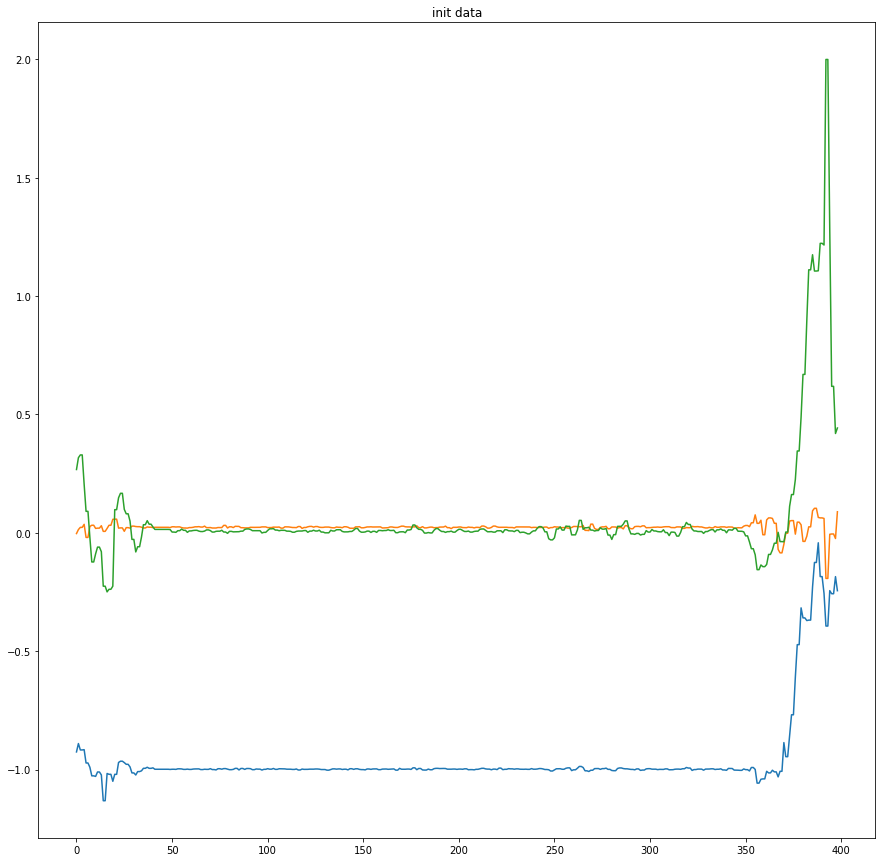

[]


In [47]:
sigma_init = np.linalg.norm(np.var(init_data[:, :3], axis=0))
print("sigma_init:", sigma_init)

total_intervals = 20
s_intervals_opt = []
params_acc = []
threshold_opt = []
for i in range(1, 1 + 1):
    threshold = i * sigma_init**2
    print("t", threshold)
    print(get_static_intervals(threshold, remaining_data, 4, samples_per_second))
    